> # INTRODUCTION
This AI project presents a model to predict Schizophrenia using health records obtained from the University of Lagos Teaching Hospital Nigeria. Dataset cases were recorded between years 2013 and 2018. The dataset contains features of diagnosis of schizophrenia as defined in DSM-5: Occupation, Marital status, Episode duration, Past psychiatric history, Past medical history, Family psychiatric history,Past social history,etc.  DSM-5 is a manual of psychiatric diseases diagnosis information. The health records comprise of first episode Schizophrenia patients and those of other related diseases. In the work, I represented Schizophrenia cases with SCHIZ class(1) and and others as OIHERS(0).

In [1]:
#import needed tools
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import KernelPCA
from sklearn.feature_selection import chi2,SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pandas as pd 
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as pl
import numpy as np
import seaborn as sn

In [25]:
#Import and view data
data=pd.read_csv('used_PROJECT_DATANEW.csv')
data.head(3)

,Y_O_REP,AGE,SEX,OCCUP,MAR_STA,DUR_EPIS,P_PSY_HX,P_MED_HX,FAM_P_HX,P_SOC_HX,...,INT_GFK,INT_S_A_D,INT_CAL,INT_PROV,JUDGMT,INSIGHT,PSE,EEG,DIAGN,CLASS
0,2015,56,F,NURSE,WIDOW,0.5,RAPE,HYPTENSIVE,NO,YES,...,NaN,NaN,NaN,NaN,NaN,PARTIAL,GOOD,NORMAL,PARANOID SCHIZ,SCHIZ
1,2016,28,F,UNEMPLOYED,MARRIED,48.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,POOR,POOR,GOOD,NORMAL,PARANOID SCHIZ,SCHIZ
2,2016,26,M,UNEMPLOYED,SINGLE,1.0,NO,SHORT-SIGHT,NO,NO,...,NaN,NaN,NaN,NaN,POOR,PARTIAL,GOOD,NORMAL,PARANOID SCHIZ,SCHIZ


In [3]:
#Shape of data 
data.shape

(151, 38)

In [4]:
#Age, Sex,Year of Report, and Diagnosis status are not part of diagnosis criteria and thus should be removed
#Let's leave age for now
data=data.drop(['SEX','Y_O_REP','DIAGN'],axis=1)


In [5]:
#Description of numerical data: duration of episode of the disease in patient in months.
data.describe()

,AGE,DUR_EPIS
count,151.000000,148.000000
mean,34.933775,60.454392
std,16.265984,94.876831
min,16.000000,0.500000
25%,22.000000,2.000000
50%,31.000000,24.000000
75%,45.000000,60.000000
max,80.000000,384.000000


- People don't report for medical attension on time as shown in __Average Duration__ of episode below


- Statistics shows that __average age__ of Schiz patients at Lagos Teaching Hospital is 35+/-16 years 

In [6]:
#Age not part of diagnosis criteria and thus is removed
data=data.drop(['AGE'],axis=1)
data.shape


(151, 34)

In [7]:
#Check missing values
data.isnull().sum()

OCCUP          6
MAR_STA        2
DUR_EPIS       3
P_PSY_HX      17
P_MED_HX      30
FAM_P_HX      21
P_SOC_HX      13
P_SEX_HX      28
FOR_HX        20
PREMOBD_HX    28
MSE            0
SPEECH         7
MOOD           8
AFFECT        10
TH_FORM       43
TH_STRM       39
TH_CONTENT    27
TH_POSS       58
PERCEP        39
ORIENT        31
ATTEN         25
CONC          25
MEM_IR        35
MEM_ST        35
MEM_LT        35
INT_GFK       62
INT_S_A_D     64
INT_CAL       67
INT_PROV      67
JUDGMT        31
INSIGHT       20
PSE            4
EEG            0
CLASS          0
dtype: int64

In [8]:
#Replace missing values with mode values of corresponding column. It is assumed that majority values represent the reality.
imputer=SimpleImputer(missing_values=np.nan,strategy='most_frequent')
newdata=imputer.fit_transform(data)
newdata=pd.DataFrame(newdata)
newdata.head(3)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,NURSE,WIDOW,0.5,RAPE,HYPTENSIVE,NO,YES,NORMAL,NO,NORMAL,...,GOOD,GOOD,GOOD,GOOD,GOOD,POOR,PARTIAL,GOOD,NORMAL,SCHIZ
1,UNEMPLOYED,MARRIED,48,MENTAL ILLNESS,NO,NO,NO,NORMAL,NO,NORMAL,...,FAIR,GOOD,GOOD,GOOD,GOOD,POOR,POOR,GOOD,NORMAL,SCHIZ
2,UNEMPLOYED,SINGLE,1,NO,SHORT-SIGHT,NO,NO,NORMAL,YES,NORMAL,...,GOOD,GOOD,GOOD,GOOD,GOOD,POOR,PARTIAL,GOOD,NORMAL,SCHIZ


In [9]:
#Only column 2 (Duration of episode) is numeric
#separation of Numeric column from categorical columns
Num_col=newdata.pop(2)

#rename categorical dataframe
Cat_columns=newdata
#Separate Target column
class_=Cat_columns.pop(33)

Num_col.shape,Cat_columns.shape

((151,), (151, 32))

In [10]:
#Encode categorical data
cat_encoder=OneHotEncoder(sparse=False)
encoded_features=cat_encoder.fit_transform(Cat_columns)

#Scale Numerical data
num_scaler=StandardScaler()
encoded_num=num_scaler.fit_transform(Num_col[:,None])

#encoding Classes into Schiz(1),Others(0)
class_encoder=LabelEncoder()
enc_target=class_encoder.fit_transform(class_)
#Combine both Numeric and categorical encoded
Full_features=np.hstack([encoded_num,encoded_features])
Full_data=np.hstack([Full_features,enc_target[:,None]])
#check dataset sizes
Full_data.shape,enc_target.shape,Full_features.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


((151, 161), (151,), (151, 160))

Text(0.5, 1.0, 'Variance of Dummies')

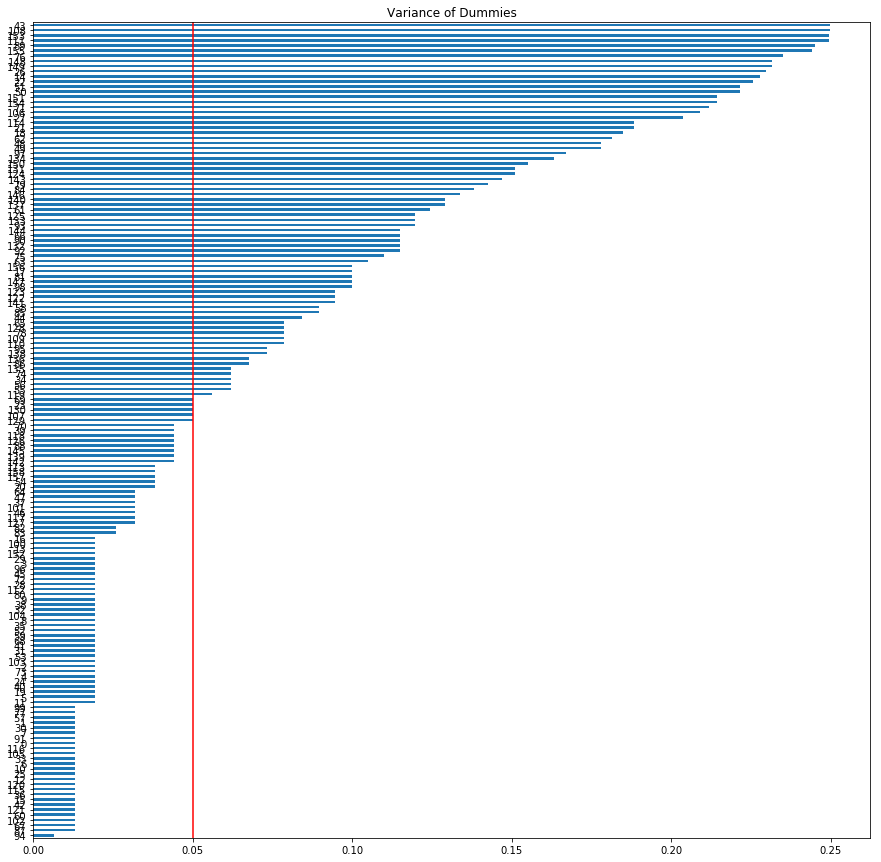

In [11]:
#Remove dummies with low variance
Variance=pd.Series(encoded_features.var(axis=0))

# let's check dummies with variance less than or equal to 0.05 and drop them
fig,ax=pl.subplots(figsize=(15,15))
Variance.sort_values().plot(kind='barh',ax=ax)
ax.vlines(0.05,ymin=-5,ymax=200,colors='red')
ax.set_title('Variance of Dummies')

In [12]:
#select dummies whose variance is greater than 0.05
Selected_Dummies=(encoded_features.T)[Variance>0.05]

#Combine selected Dummies and sole numerical column
Full_features=np.vstack([Selected_Dummies,encoded_num.flatten()])
Full_features=Full_features.T
#check for data consistency
Selected_Dummies.T.shape, Full_features.shape

((151, 78), (151, 79))

In [13]:
#split data into train-test portions
#apply split data function to dataset
Train_features,Test_features,Train_targets,Test_targets=train_test_split(Full_features,enc_target,test_size=0.2, 
                                                                         stratify=enc_target, random_state=1)
#check data shape consistency
Train_features.shape,Test_features.shape,Train_targets.shape,Test_targets.shape

((120, 79), (31, 79), (120,), (31,))

# **Time for algorithm training**

In [14]:
#making trials with 4 algorithms:'SVC','DecisionTree','Randomforest','GradientBoosting
models=pd.DataFrame(index=['Accuracy','Precision','Recall'],columns=['SVC','DecisionTree','Randomforest','GradientBoosting'])


In [15]:
#Train Gradient Boosting Classifier with say 30 features
pipeline1=make_pipeline(KernelPCA(kernel='rbf',n_components=30),GradientBoostingClassifier(n_estimators=10,random_state=1))
Model_gbc=pipeline1.fit(Train_features,Train_targets)
y_gbc=Model_gbc.predict(Train_features)
models.loc['Accuracy','GradientBoosting']=Model_gbc.score(Train_features,Train_targets)
models.loc['Precision','GradientBoosting']=precision_score(Train_targets,y_gbc)
models.loc['Recall','GradientBoosting']=recall_score(Train_targets,y_gbc)

In [16]:
#Train DecisionTreeClassifier Classifier with say 30 features
pipeline2=make_pipeline(KernelPCA(kernel='rbf',n_components=30),DecisionTreeClassifier(random_state=1))
Model_dtc=pipeline2.fit(Train_features,Train_targets)
y_dtc=Model_gbc.predict(Train_features)
models.loc['Accuracy','DecisionTree']=Model_dtc.score(Train_features,Train_targets)
models.loc['Precision','DecisionTree']=precision_score(Train_targets,y_dtc)
models.loc['Recall','DecisionTree']=recall_score(Train_targets,y_dtc)

In [17]:
#Train SVClassifier Classifier with say 30 features
pipeline3=make_pipeline(KernelPCA(kernel='rbf',n_components=30),SVC(kernel='rbf',random_state=1))
Model_svc=pipeline3.fit(Train_features,Train_targets)
y_svc=Model_svc.predict(Train_features)
models.loc['Accuracy','SVC']=Model_svc.score(Train_features,Train_targets)
models.loc['Precision','SVC']=precision_score(Train_targets,y_svc)
models.loc['Recall','SVC']=recall_score(Train_targets,y_svc)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [18]:
#Reduce dimension with Principal Components analysis and Train the RandomForestClassifier classifier
pipeline4=make_pipeline(KernelPCA(kernel='rbf',n_components=30),RandomForestClassifier(n_estimators=10,class_weight='balanced',random_state=1))
Model_rfc=pipeline4.fit(Train_features,Train_targets)
y_rfc=Model_svc.predict(Train_features)
models.loc['Accuracy','Randomforest']=Model_rfc.score(Train_features,Train_targets)
models.loc['Precision','Randomforest']=precision_score(Train_targets,y_rfc)
models.loc['Recall','Randomforest']=recall_score(Train_targets,y_rfc)

In [19]:
#print models performances
models

,SVC,DecisionTree,Randomforest,GradientBoosting
Accuracy,0.641667,1,1,0.991667
Precision,0.641667,0.987179,0.641667,0.987179
Recall,1,1,1,1


                SVC DecisionTree Randomforest GradientBoosting
Accuracy   0.641667            1            1         0.991667
Precision  0.641667     0.987179     0.641667         0.987179
Recall            1            1            1                1


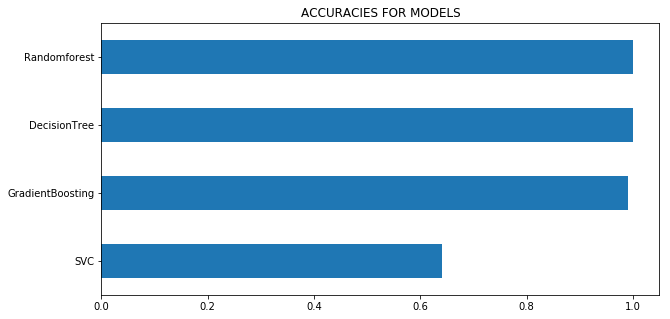

In [20]:
#Print model performances on data
fig,ax=pl.subplots(figsize=(10,5))
models.loc['Accuracy'].sort_values().plot(kind='barh',ax=ax)
ax.set_title('ACCURACIES FOR MODELS')
print(models)

# **DecisionTree Classifier looks the best among the classifiers trained**

In [21]:
#validate Decisiontree Classifier with Cross-Validation scheme
num_folds = 10
accuracy_values =cross_val_score(Model_dtc,Train_features,Train_targets, scoring='accuracy', cv=num_folds)
print("Validation Accuracy: " + str(round(100*accuracy_values.mean(), 2)) + "%")
precision_values =cross_val_score(Model_dtc,Train_features,Train_targets, scoring='precision_weighted', cv=num_folds)
print("Precision: " + str(round(100*precision_values.mean(), 2)) + "%")
recall_values = cross_val_score(Model_dtc, Train_features,Train_targets, scoring='recall_weighted', cv=num_folds)
print("Recall: " + str(round(100*recall_values.mean(), 2)) + "%")
f1_values = cross_val_score(Model_dtc,Train_features,Train_targets, scoring='f1_weighted', cv=num_folds)
print("F1: " + str(round(100*f1_values.mean(), 2)) + "%")

Validation Accuracy: 94.07%
Precision: 95.56%
Recall: 94.07%
F1: 94.1%


## __Test Model on unseen data__

In [22]:
#Test the model on unseen datset
y_pred=Model_dtc.predict(Test_features)
score=round((100*(y_pred==Test_targets).sum()/len(Test_features)),2)
print('Test Accuracy:' + str(score) + '%')

V={"Predicts":y_pred,'Targets':Test_targets}
pd.DataFrame(V).head(25)


Test Accuracy:96.77%


,Predicts,Targets
0,1,1
1,0,0
2,0,0
3,0,0
4,1,1
5,0,0
6,1,1
7,0,0
8,1,1
9,1,1


In [23]:
#predict a case
case=Test_features[2,:]
print('Predicated status: %s, Real status: %s'%(Model_dtc.predict(case[np.newaxis,:]),Test_targets[2]))
class_encoder.inverse_transform(Model_gbc.predict(case[np.newaxis,:]))


Predicated status: [0], Real status: 0


array(['OTHERS'], dtype=object)

In [24]:
#save the best model for the prediction of Schizophrenia at 93% accuracy and recall 

from sklearn.externals import joblib
joblib.dump(Model_gbc,"SCHIZ_model.pkl" )

['SCHIZ_model.pkl']

# Thanks!!!